**Import Libraries**


In this section, we import the required Python libraries for data preprocessing, model development, training, and evaluation. Pandas and NumPy are used for data handling and numerical operations, while Scikit-learn provides tools for feature scaling and evaluation metrics such as MAE, RMSE, and R². TensorFlow and Keras are employed to build and train the LSTM-based deep learning models. Matplotlib is used for visualizing model performance and forecasting results. This computational setup enables efficient implementation of multivariate, multi-step electricity demand forecasting models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


**Load dataset**

In [ ]:
# Load your CSV
df = pd.read_csv('/content/electricitydemanddata.csv')

# Inspect columns
print(df.columns.tolist())
print(df.head())


['Date', 'Day of the week', 'Year', 'Month', 'Max. Demand at eve. peak (Generation end)', 'Max. Demand at eve. peak (Sub-station end)', 'Highest Generation (Generation end)', 'Minimum Generation (Generation end)', 'Day-peak Generation (Generation end)', 'Evening-peak Generation (Generation end)', 'Minimum Generation Forecast up to 8:00 hrs.', 'Maximum Temperature in Dhaka was', 'Gas/LF limitation', 'Coal supply Limitation', 'Low water level in Kaptai lake', 'Plants under shut down/ maintenance', 'Dhaka_demand', 'Dhaka_supply', 'Dhaka_load', 'Chattogram_demand', 'Chattogram_supply', 'Chattogram_load', 'Rajshahi_demand', 'Rajshahi_supply', 'Rajshahi_load', 'Mymensingh_demand', 'Mymensingh_supply', 'Mymensingh_load', 'Sylhet_demand', 'Sylhet_supply', 'Sylhet_load', 'Barishal_demand', 'Barishal_supply', 'Barishal_load', 'Rangpur_demand', 'Rangpur_supply', 'Rangpur_load', 'Cumilla_demand', 'Cumilla_supply', 'Cumilla_load', 'Khulna_demand', 'Khulna_supply', 'Khulna_load', 'Holiday name', 'Ho

**Data Preprocessing and Feature Engineering**


This step performs data preprocessing and feature engineering to prepare the dataset for deep learning modeling. Boolean variables are converted to numerical format, and non-numeric columns such as dates and holiday names are removed. Categorical features, including day of the week, month, and holiday category,

In [ ]:
# Convert boolean columns to float
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

# Drop non-numeric column 'Date' and 'Holiday name'
df = df.drop(columns=['Date', 'Holiday name'])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['Day of the week', 'Month', 'Holiday_cat'], drop_first=True)

# Identify feature and target columns
target_cols = [col for col in df.columns if '_demand' in col]  # all regional demand columns
feature_cols = [col for col in df.columns if col not in target_cols]

X = df[feature_cols].values.astype(np.float32)
y = df[target_cols].values.astype(np.float32)

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X = feature_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)


**Sequence Construction for Multi-Step LSTM Forecasting**

This step transforms the scaled feature and target matrices into supervised learning sequences suitable for LSTM modeling. A sliding window approach is used to create input sequences of a fixed lookback period, while the corresponding output consists of multi-step future regional electricity demand values over the defined forecast horizon. This formulation enables the model to learn temporal dependencies and generate multi-step forecasts for multiple regions simultaneously.

In [ ]:
def create_lstm_dataset_multioutput(X, y, lookback=21, horizon=2):
    Xs, ys = [], []
    for i in range(lookback, len(X)-horizon+1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i:i+horizon])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

lookback = 21  # input window
horizon = 2    # 48-hour forecast (2 days)

X_lstm, y_lstm = create_lstm_dataset_multioutput(X, y, lookback, horizon)

print("X shape:", X_lstm.shape)  # (samples, lookback, num_features)
print("y shape:", y_lstm.shape)  # (samples, horizon, num_regions)


X shape: (1828, 21, 51)
y shape: (1828, 2, 9)


**Train–Validation–Test Split**

In this step, the sequential dataset is partitioned into training, validation, and test subsets using a chronological split to preserve the temporal order of the time-series data. Seventy percent of the samples are allocated for model training, fifteen percent for validation during hyperparameter tuning, and the remaining fifteen percent for final performance evaluation. This strategy prevents information leakage from future data and ensures a realistic forecasting setup.

In [ ]:
total_samples = len(X_lstm)
train_end = int(total_samples * 0.7)
val_end = int(total_samples * 0.85)

X_train, y_train = X_lstm[:train_end], y_lstm[:train_end]
X_val, y_val = X_lstm[train_end:val_end], y_lstm[train_end:val_end]
X_test, y_test = X_lstm[val_end:], y_lstm[val_end:]

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)


Train: (1279, 21, 51) Validation: (274, 21, 51) Test: (275, 21, 51)


**LSTM Model Architecture**

This cell defines a multi-output LSTM model for short-term electricity demand forecasting. The network consists of two stacked LSTM layers to capture both short- and long-term temporal dependencies in the input sequences. The first LSTM layer returns full sequences to allow deeper temporal feature extraction, while the second LSTM layer summarizes the learned patterns into a fixed-length representation. Dropout layers are included after each LSTM layer to reduce overfitting. The final dense layer outputs a flattened vector corresponding to the multi-step forecasting horizon across all target regions. The model is trained using the Adam optimizer with mean squared error (MSE) as the loss function.

In [ ]:
num_features = X_train.shape[2]
num_targets = y_train.shape[2]

model = Sequential()
model.add(LSTM(64, input_shape=(lookback, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(horizon * num_targets))  # flatten output

# reshape output to (horizon, num_targets)
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,706 (166.82 KB)

 Trainable params: 42,706 (166.82 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

This cell trains the LSTM model using the training dataset only. The multi-step target output is reshaped into a flattened format to match the dimensionality of the final dense layer. The model is trained for 50 epochs with a batch size of 32 using backpropagation through time. Training progress is reported at each epoch, allowing monitoring of convergence behavior.

In [ ]:
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),  # flatten target for Dense
    epochs=50,
    batch_size=32,
    verbose=2
)


Epoch 1/50
40/40 - 5s - 117ms/step - loss: 0.0669
Epoch 2/50
40/40 - 1s - 20ms/step - loss: 0.0243
Epoch 3/50
40/40 - 1s - 36ms/step - loss: 0.0197
Epoch 4/50
40/40 - 1s - 36ms/step - loss: 0.0177
Epoch 5/50
40/40 - 1s - 31ms/step - loss: 0.0160
Epoch 6/50
40/40 - 1s - 23ms/step - loss: 0.0147
Epoch 7/50
40/40 - 1s - 21ms/step - loss: 0.0139
Epoch 8/50
40/40 - 1s - 21ms/step - loss: 0.0131
Epoch 9/50
40/40 - 1s - 20ms/step - loss: 0.0124
Epoch 10/50
40/40 - 1s - 32ms/step - loss: 0.0120
Epoch 11/50
40/40 - 1s - 20ms/step - loss: 0.0113
Epoch 12/50
40/40 - 1s - 20ms/step - loss: 0.0109
Epoch 13/50
40/40 - 1s - 31ms/step - loss: 0.0108
Epoch 14/50
40/40 - 1s - 21ms/step - loss: 0.0102
Epoch 15/50
40/40 - 1s - 21ms/step - loss: 0.0099
Epoch 16/50
40/40 - 1s - 28ms/step - loss: 0.0097
Epoch 17/50
40/40 - 1s - 35ms/step - loss: 0.0093
Epoch 18/50
40/40 - 1s - 27ms/step - loss: 0.0095
Epoch 19/50
40/40 - 1s - 22ms/step - loss: 0.0089
Epoch 20/50
40/40 - 1s - 21ms/step - loss: 0.0092
Epoch 21

**Evaluate on Training Set**

This cell evaluates the trained LSTM model on the training set. Predictions are reshaped to match the multi-step target format and then inverse-transformed to original MW units. Key metrics—MAE, RMSE, MAPE, and R²—are computed to assess model performance on training data. Additionally, the first region’s multi-step forecast (Day 1 and Day 2) is plotted to visually compare predicted vs actual electricity demand.

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Train Metrics:
MAE: 60.91
RMSE: 111.82
MAPE: 5.43%
R²: 0.86


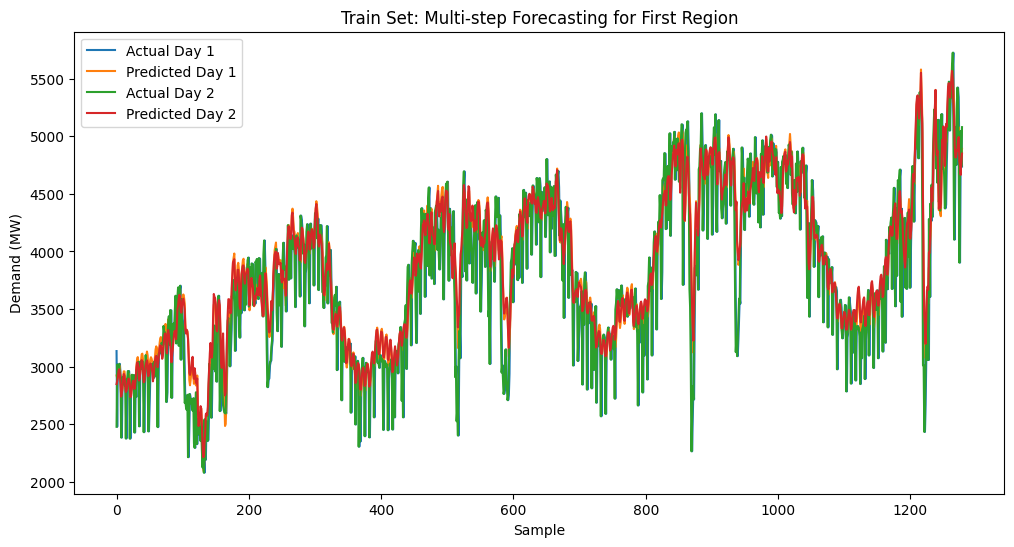

In [ ]:
# Predict on training set
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(y_train.shape[0], horizon, num_targets)

# Inverse scaling to original MW
y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, num_targets)).reshape(y_train.shape)
y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.reshape(-1, num_targets)).reshape(y_train_pred.shape)

# Metrics
mae_train = mean_absolute_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))
rmse_train = np.sqrt(mean_squared_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets)))
mape_train = np.mean(np.abs((y_train_inv - y_train_pred_inv) / y_train_inv)) * 100
r2_train = r2_score(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))

print("Train Metrics:")
print(f"MAE: {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R²: {r2_train:.2f}")

# Optional: plot first region, Day 1 vs Day 2
plt.figure(figsize=(12,6))
plt.plot(y_train_inv[:,0,0], label='Actual Day 1')
plt.plot(y_train_pred_inv[:,0,0], label='Predicted Day 1')
plt.plot(y_train_inv[:,1,0], label='Actual Day 2')
plt.plot(y_train_pred_inv[:,1,0], label='Predicted Day 2')
plt.legend()
plt.title('Train Set: Multi-step Forecasting for First Region')
plt.xlabel('Sample')
plt.ylabel('Demand (MW)')
plt.show()


**Evaluate on Validation Set**

This cell evaluates the trained LSTM model on the validation set to monitor how well the model generalizes to unseen data. Predictions are reshaped to the multi-step target format and inverse-transformed back to actual MW values. Key metrics—MAE, RMSE, MAPE, and R²—are calculated to assess model performance on the validation data.

In [ ]:
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)

# Inverse scaling
y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

# Metrics
mae_val = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))
rmse_val = np.sqrt(mean_squared_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets)))
mape_val = np.mean(np.abs((y_val_inv - y_val_pred_inv) / y_val_inv)) * 100
r2_val = r2_score(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

print("Validation Metrics:")
print(f"MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%, R²: {r2_val:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation Metrics:
MAE: 91.23, RMSE: 160.21, MAPE: 7.42%, R²: 0.70


**Evaluate on Test Set**

This cell evaluates the trained LSTM model on the test set, which represents completely unseen data, to assess the model’s final performance. Predictions are reshaped back to the multi-step target format and inverse-transformed to actual MW values. Metrics like MAE, RMSE, MAPE, and R² quantify how well the model forecasts electricity demand for all regions.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Test Metrics:
MAE: 108.14, RMSE: 186.30, MAPE: 8.43%, R²: 0.58


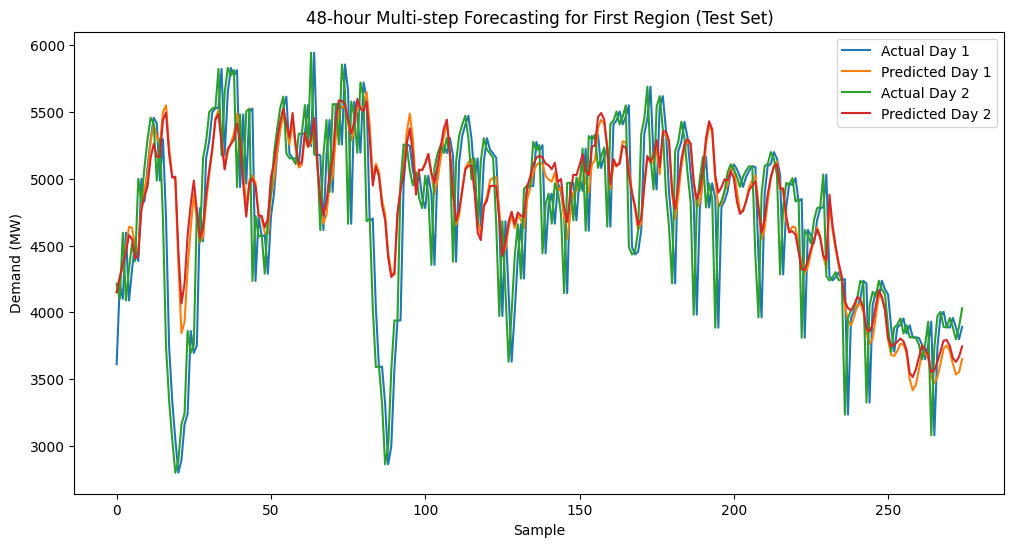

In [ ]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test.shape[0], horizon, num_targets)

# Inverse scaling
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, num_targets)).reshape(y_test.shape)
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred.reshape(-1, num_targets)).reshape(y_test_pred.shape)

# Metrics
mae_test = mean_absolute_error(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets))
rmse_test = np.sqrt(mean_squared_error(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets)))
mape_test = np.mean(np.abs((y_test_inv - y_test_pred_inv) / y_test_inv)) * 100
r2_test = r2_score(y_test_inv.reshape(-1, num_targets), y_test_pred_inv.reshape(-1, num_targets))

print("Test Metrics:")
print(f"MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.2f}")

# Plot example: Day 1 for first region
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:,0,0], label='Actual Day 1')
plt.plot(y_test_pred_inv[:,0,0], label='Predicted Day 1')
plt.plot(y_test_inv[:,1,0], label='Actual Day 2')
plt.plot(y_test_pred_inv[:,1,0], label='Predicted Day 2')
plt.legend()
plt.title('48-hour Multi-step Forecasting for First Region (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Demand (MW)')
plt.show()


**The below implementation is on hyper parameter tuning**

Install Keras Tuner (if not installed)

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.5 MB/s eta 0:00:00


**Import Libraries**

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


**Define Model Builder for Hyperparameter Tuning**

This function defines a Keras LSTM model with tunable hyperparameters using keras-tuner.
The model is designed for multi-step, multi-region electricity demand forecasting.

In [ ]:
def build_lstm_model(hp):
    num_features = X_train.shape[2]
    num_targets = y_train.shape[2]

    model = Sequential()

    # LSTM layer 1
    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        input_shape=(lookback, num_features),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))

    # LSTM layer 2
    model.add(LSTM(
        units=hp.Int('units2', min_value=16, max_value=64, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense output layer
    model.add(Dense(horizon * num_targets))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )

    return model


**Hyperparameter Tuning with Random Search**

This cell sets up random search hyperparameter tuning using keras-tuner.
The goal is to find the best combination of LSTM units, dropout rates, and learning rate to minimize the validation loss (MSE).

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,  # number of hyperparameter combinations to try
    executions_per_trial=1,
    overwrite=True,
    directory='lstm_tuner',
    project_name='regional_demand'
)

tuner.search_space_summary()


Search space summary
Default search space size: 5
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Run Random Search for Hyperparameter Tuning**

This cell runs the hyperparameter search using the previously defined RandomSearch tuner.
The tuner will train multiple LSTM models on the training set and evaluate them on the validation set to find the best hyperparameters.

In [ ]:
tuner.search(
    X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val.reshape(y_val.shape[0], horizon*num_targets)),
    verbose=2
)


Trial 10 Complete [00h 00m 29s]
val_loss: 0.007531057111918926

Best val_loss So Far: 0.007531057111918926
Total elapsed time: 00h 05m 25s


**Get the Best Model**


**Build Model with Best Hyperparameters**


This cell extracts the best hyperparameters found by the RandomSearch tuner and builds a new LSTM model using these values.
The model is not yet trained on the full training set; it will be trained in the next step.

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(best_hp.values)

# Build best model
model = tuner.hypermodel.build(best_hp)


Best Hyperparameters:
{'units1': 32, 'dropout1': 0.30000000000000004, 'units2': 16, 'dropout2': 0.1, 'learning_rate': 0.01}


**Train Best Model on Train Set Only**

In this cell, we train the LSTM model built with the best hyperparameters found from the Random Search tuner.
The training is performed only on the training set (X_train, y_train) without validation, so we can later evaluate on the validation set separately.

In [ ]:
# Build the best model from tuner
model = tuner.hypermodel.build(best_hp)

# Train on training set only
history = model.fit(
    X_train,
    y_train.reshape(y_train.shape[0], horizon*num_targets),  # flatten output for multi-step
    epochs=50,
    batch_size=32,
    verbose=2
)


Epoch 1/50
40/40 - 5s - 134ms/step - loss: 0.0339
Epoch 2/50
40/40 - 1s - 18ms/step - loss: 0.0130
Epoch 3/50
40/40 - 1s - 18ms/step - loss: 0.0109
Epoch 4/50
40/40 - 1s - 18ms/step - loss: 0.0093
Epoch 5/50
40/40 - 1s - 32ms/step - loss: 0.0085
Epoch 6/50
40/40 - 1s - 18ms/step - loss: 0.0081
Epoch 7/50
40/40 - 1s - 18ms/step - loss: 0.0078
Epoch 8/50
40/40 - 1s - 29ms/step - loss: 0.0070
Epoch 9/50
40/40 - 1s - 17ms/step - loss: 0.0070
Epoch 10/50
40/40 - 1s - 19ms/step - loss: 0.0067
Epoch 11/50
40/40 - 1s - 19ms/step - loss: 0.0067
Epoch 12/50
40/40 - 1s - 18ms/step - loss: 0.0066
Epoch 13/50
40/40 - 1s - 19ms/step - loss: 0.0064
Epoch 14/50
40/40 - 1s - 33ms/step - loss: 0.0063
Epoch 15/50
40/40 - 2s - 50ms/step - loss: 0.0063
Epoch 16/50
40/40 - 1s - 32ms/step - loss: 0.0061
Epoch 17/50
40/40 - 1s - 19ms/step - loss: 0.0061
Epoch 18/50
40/40 - 1s - 31ms/step - loss: 0.0060
Epoch 19/50
40/40 - 1s - 30ms/step - loss: 0.0058
Epoch 20/50
40/40 - 1s - 19ms/step - loss: 0.0061
Epoch 21

**Evaluate on Training Set**


In this cell, we evaluate the trained LSTM model on the training set to check how well it has learned the patterns from the training data.

In [ ]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(y_train.shape[0], horizon, num_targets)

y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, num_targets)).reshape(y_train.shape)
y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.reshape(-1, num_targets)).reshape(y_train_pred.shape)

mae_train = mean_absolute_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))
rmse_train = np.sqrt(mean_squared_error(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets)))
mape_train = np.mean(np.abs((y_train_inv - y_train_pred_inv) / y_train_inv)) * 100
r2_train = r2_score(y_train_inv.reshape(-1, num_targets), y_train_pred_inv.reshape(-1, num_targets))

print("Train Metrics:")
print(f"MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.2f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Train Metrics:
MAE: 55.05, RMSE: 96.85, MAPE: 4.89%, R²: 0.88


**Evaluate on Validation Set**

In this cell, we evaluate the trained LSTM model on the validation set to monitor how well the model generalizes to unseen data during hyperparameter tuning or training.

In [ ]:
y_val_pred = model.predict(X_val)
y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)

y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

mae_val = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))
rmse_val = np.sqrt(mean_squared_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets)))
mape_val = np.mean(np.abs((y_val_inv - y_val_pred_inv) / y_val_inv)) * 100
r2_val = r2_score(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

print("Validation Metrics:")
print(f"MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%, R²: {r2_val:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation Metrics:
MAE: 85.05, RMSE: 152.37, MAPE: 6.75%, R²: 0.74


**Hyperparameter tuning with Grid technique**



**Define Hyperparameter Grid for LSTM**

In this cell, we define a grid of hyperparameters for our LSTM model. These hyperparameters will be used in a Grid Search or Random Search to find the best model configuration.

In [ ]:
# Hyperparameter grid
units1_list = [32, 64, 128]
units2_list = [16, 32, 64]
dropout1_list = [0.1, 0.2, 0.3]
dropout2_list = [0.1, 0.2, 0.3]
learning_rate_list = [1e-2, 1e-3]


**Grid Search Loop**

In this cell, we perform a grid search to find the best LSTM model configuration for multi-output regional electricity demand forecasting.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

best_val_mae = float('inf')
best_params = None
best_model = None

for units1 in units1_list:
    for units2 in units2_list:
        for dropout1 in dropout1_list:
            for dropout2 in dropout2_list:
                for lr in learning_rate_list:

                    # Build model
                    model = Sequential()
                    model.add(LSTM(units1, input_shape=(lookback, X_train.shape[2]), return_sequences=True))
                    model.add(Dropout(dropout1))
                    model.add(LSTM(units2, return_sequences=False))
                    model.add(Dropout(dropout2))
                    model.add(Dense(horizon * num_targets))

                    model.compile(optimizer=Adam(lr), loss='mse')

                    # Train on training set only
                    model.fit(
                        X_train, y_train.reshape(y_train.shape[0], horizon*num_targets),
                        epochs=20, batch_size=32, verbose=0
                    )

                    # Evaluate on validation set
                    y_val_pred = model.predict(X_val)
                    y_val_pred = y_val_pred.reshape(y_val.shape[0], horizon, num_targets)
                    y_val_inv = target_scaler.inverse_transform(y_val.reshape(-1, num_targets)).reshape(y_val.shape)
                    y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.reshape(-1, num_targets)).reshape(y_val_pred.shape)

                    val_mae = mean_absolute_error(y_val_inv.reshape(-1, num_targets), y_val_pred_inv.reshape(-1, num_targets))

                    print(f"units1:{units1}, units2:{units2}, d1:{dropout1}, d2:{dropout2}, lr:{lr}, val_mae:{val_mae:.2f}")

                    if val_mae < best_val_mae:
                        best_val_mae = val_mae
                        best_params = (units1, units2, dropout1, dropout2, lr)
                        best_model = model


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:16, d1:0.1, d2:0.1, lr:0.01, val_mae:79.72


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
units1:32, units2:16, d1:0.1, d2:0.1, lr:0.001, val_mae:97.86


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
units1:32, units2:16, d1:0.1, d2:0.2, lr:0.01, val_mae:80.30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
units1:32, units2:16, d1:0.1, d2:0.2, lr:0.001, val_mae:97.82


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:16, d1:0.1, d2:0.3, lr:0.01, val_mae:84.66


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
units1:32, units2:16, d1:0.1, d2:0.3, lr:0.001, val_mae:105.92


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
units1:32, units2:16, d1:0.2, d2:0.1, lr:0.01, val_mae:84.99


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
units1:32, units2:16, d1:0.2, d2:0.1, lr:0.001, val_mae:102.52


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:32, units2:16, d1:0.2, d2:0.2, lr:0.01, val_mae:90.71


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:16, d1:0.2, d2:0.2, lr:0.001, val_mae:104.87


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:16, d1:0.2, d2:0.3, lr:0.01, val_mae:90.49


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:16, d1:0.2, d2:0.3, lr:0.001, val_mae:98.23


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:91.62


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
units1:32, units2:16, d1:0.3, d2:0.1, lr:0.001, val_mae:92.95


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:16, d1:0.3, d2:0.2, lr:0.01, val_mae:86.03


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
units1:32, units2:16, d1:0.3, d2:0.2, lr:0.001, val_mae:99.12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
units1:32, units2:16, d1:0.3, d2:0.3, lr:0.01, val_mae:92.74


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
units1:32, units2:16, d1:0.3, d2:0.3, lr:0.001, val_mae:107.17


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:32, d1:0.1, d2:0.1, lr:0.01, val_mae:92.57


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:32, units2:32, d1:0.1, d2:0.1, lr:0.001, val_mae:84.27


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
units1:32, units2:32, d1:0.1, d2:0.2, lr:0.01, val_mae:82.29


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
units1:32, units2:32, d1:0.1, d2:0.2, lr:0.001, val_mae:99.92


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:32, d1:0.1, d2:0.3, lr:0.01, val_mae:83.23


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
units1:32, units2:32, d1:0.1, d2:0.3, lr:0.001, val_mae:88.80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:32, units2:32, d1:0.2, d2:0.1, lr:0.01, val_mae:91.04


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:32, units2:32, d1:0.2, d2:0.1, lr:0.001, val_mae:95.43


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:32, d1:0.2, d2:0.2, lr:0.01, val_mae:79.62


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:32, d1:0.2, d2:0.2, lr:0.001, val_mae:92.60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:32, units2:32, d1:0.2, d2:0.3, lr:0.01, val_mae:82.31


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:32, d1:0.2, d2:0.3, lr:0.001, val_mae:96.17


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:32, d1:0.3, d2:0.1, lr:0.01, val_mae:89.49


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:32, d1:0.3, d2:0.1, lr:0.001, val_mae:97.06


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:32, d1:0.3, d2:0.2, lr:0.01, val_mae:85.61


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:32, d1:0.3, d2:0.2, lr:0.001, val_mae:96.52


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:32, d1:0.3, d2:0.3, lr:0.01, val_mae:84.98


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
units1:32, units2:32, d1:0.3, d2:0.3, lr:0.001, val_mae:97.85


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:32, units2:64, d1:0.1, d2:0.1, lr:0.01, val_mae:83.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:32, units2:64, d1:0.1, d2:0.1, lr:0.001, val_mae:90.99


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:32, units2:64, d1:0.1, d2:0.2, lr:0.01, val_mae:77.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:64, d1:0.1, d2:0.2, lr:0.001, val_mae:89.51


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:32, units2:64, d1:0.1, d2:0.3, lr:0.01, val_mae:82.98


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
units1:32, units2:64, d1:0.1, d2:0.3, lr:0.001, val_mae:93.75


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:32, units2:64, d1:0.2, d2:0.1, lr:0.01, val_mae:92.94


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:32, units2:64, d1:0.2, d2:0.1, lr:0.001, val_mae:91.93


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
units1:32, units2:64, d1:0.2, d2:0.2, lr:0.01, val_mae:86.56


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:32, units2:64, d1:0.2, d2:0.2, lr:0.001, val_mae:88.33


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
units1:32, units2:64, d1:0.2, d2:0.3, lr:0.01, val_mae:82.59


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:32, units2:64, d1:0.2, d2:0.3, lr:0.001, val_mae:91.95


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:64, d1:0.3, d2:0.1, lr:0.01, val_mae:94.14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:64, d1:0.3, d2:0.1, lr:0.001, val_mae:89.84


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:32, units2:64, d1:0.3, d2:0.2, lr:0.01, val_mae:92.11


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:32, units2:64, d1:0.3, d2:0.2, lr:0.001, val_mae:96.31


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:32, units2:64, d1:0.3, d2:0.3, lr:0.01, val_mae:86.18


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:32, units2:64, d1:0.3, d2:0.3, lr:0.001, val_mae:102.55


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:64, units2:16, d1:0.1, d2:0.1, lr:0.01, val_mae:79.90


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
units1:64, units2:16, d1:0.1, d2:0.1, lr:0.001, val_mae:93.41


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:64, units2:16, d1:0.1, d2:0.2, lr:0.01, val_mae:83.77


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:16, d1:0.1, d2:0.2, lr:0.001, val_mae:92.75


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:64, units2:16, d1:0.1, d2:0.3, lr:0.01, val_mae:92.24


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
units1:64, units2:16, d1:0.1, d2:0.3, lr:0.001, val_mae:95.45


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:64, units2:16, d1:0.2, d2:0.1, lr:0.01, val_mae:95.44


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:16, d1:0.2, d2:0.1, lr:0.001, val_mae:95.76


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:64, units2:16, d1:0.2, d2:0.2, lr:0.01, val_mae:85.76


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:64, units2:16, d1:0.2, d2:0.2, lr:0.001, val_mae:92.88


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:64, units2:16, d1:0.2, d2:0.3, lr:0.01, val_mae:87.54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:64, units2:16, d1:0.2, d2:0.3, lr:0.001, val_mae:100.39


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:84.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
units1:64, units2:16, d1:0.3, d2:0.1, lr:0.001, val_mae:101.94


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:64, units2:16, d1:0.3, d2:0.2, lr:0.01, val_mae:82.34


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:64, units2:16, d1:0.3, d2:0.2, lr:0.001, val_mae:98.97


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:64, units2:16, d1:0.3, d2:0.3, lr:0.01, val_mae:92.90


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
units1:64, units2:16, d1:0.3, d2:0.3, lr:0.001, val_mae:100.49


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:64, units2:32, d1:0.1, d2:0.1, lr:0.01, val_mae:83.25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:32, d1:0.1, d2:0.1, lr:0.001, val_mae:89.78


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:32, d1:0.1, d2:0.2, lr:0.01, val_mae:86.61


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:64, units2:32, d1:0.1, d2:0.2, lr:0.001, val_mae:95.14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:64, units2:32, d1:0.1, d2:0.3, lr:0.01, val_mae:82.77


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
units1:64, units2:32, d1:0.1, d2:0.3, lr:0.001, val_mae:100.22


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
units1:64, units2:32, d1:0.2, d2:0.1, lr:0.01, val_mae:79.75


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:64, units2:32, d1:0.2, d2:0.1, lr:0.001, val_mae:95.41


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:32, d1:0.2, d2:0.2, lr:0.01, val_mae:81.59


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:64, units2:32, d1:0.2, d2:0.2, lr:0.001, val_mae:94.42


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:64, units2:32, d1:0.2, d2:0.3, lr:0.01, val_mae:84.67


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
units1:64, units2:32, d1:0.2, d2:0.3, lr:0.001, val_mae:91.93


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
units1:64, units2:32, d1:0.3, d2:0.1, lr:0.01, val_mae:86.72


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
units1:64, units2:32, d1:0.3, d2:0.1, lr:0.001, val_mae:98.65


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
units1:64, units2:32, d1:0.3, d2:0.2, lr:0.01, val_mae:90.54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:32, d1:0.3, d2:0.2, lr:0.001, val_mae:94.21


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:64, units2:32, d1:0.3, d2:0.3, lr:0.01, val_mae:89.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:32, d1:0.3, d2:0.3, lr:0.001, val_mae:96.54


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
units1:64, units2:64, d1:0.1, d2:0.1, lr:0.01, val_mae:91.49


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:64, units2:64, d1:0.1, d2:0.1, lr:0.001, val_mae:87.02


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:64, d1:0.1, d2:0.2, lr:0.01, val_mae:81.06


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
units1:64, units2:64, d1:0.1, d2:0.2, lr:0.001, val_mae:89.83


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:64, d1:0.1, d2:0.3, lr:0.01, val_mae:84.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
units1:64, units2:64, d1:0.1, d2:0.3, lr:0.001, val_mae:89.53


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:64, d1:0.2, d2:0.1, lr:0.01, val_mae:80.26


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:64, units2:64, d1:0.2, d2:0.1, lr:0.001, val_mae:98.48


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
units1:64, units2:64, d1:0.2, d2:0.2, lr:0.01, val_mae:84.34


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
units1:64, units2:64, d1:0.2, d2:0.2, lr:0.001, val_mae:93.61


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:64, d1:0.2, d2:0.3, lr:0.01, val_mae:82.52


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:64, units2:64, d1:0.2, d2:0.3, lr:0.001, val_mae:91.44


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:64, units2:64, d1:0.3, d2:0.1, lr:0.01, val_mae:87.89


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
units1:64, units2:64, d1:0.3, d2:0.1, lr:0.001, val_mae:94.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:64, units2:64, d1:0.3, d2:0.2, lr:0.01, val_mae:85.82


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:64, units2:64, d1:0.3, d2:0.2, lr:0.001, val_mae:91.64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:64, d1:0.3, d2:0.3, lr:0.01, val_mae:92.56


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:64, units2:64, d1:0.3, d2:0.3, lr:0.001, val_mae:94.00


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:16, d1:0.1, d2:0.1, lr:0.01, val_mae:75.89


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
units1:128, units2:16, d1:0.1, d2:0.1, lr:0.001, val_mae:94.25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:128, units2:16, d1:0.1, d2:0.2, lr:0.01, val_mae:86.21


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:128, units2:16, d1:0.1, d2:0.2, lr:0.001, val_mae:93.41


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
units1:128, units2:16, d1:0.1, d2:0.3, lr:0.01, val_mae:86.61


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
units1:128, units2:16, d1:0.1, d2:0.3, lr:0.001, val_mae:104.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
units1:128, units2:16, d1:0.2, d2:0.1, lr:0.01, val_mae:85.13


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:16, d1:0.2, d2:0.1, lr:0.001, val_mae:94.14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:128, units2:16, d1:0.2, d2:0.2, lr:0.01, val_mae:90.52


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:16, d1:0.2, d2:0.2, lr:0.001, val_mae:95.92


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:16, d1:0.2, d2:0.3, lr:0.01, val_mae:95.73


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:128, units2:16, d1:0.2, d2:0.3, lr:0.001, val_mae:99.32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:128, units2:16, d1:0.3, d2:0.1, lr:0.01, val_mae:83.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
units1:128, units2:16, d1:0.3, d2:0.1, lr:0.001, val_mae:93.90


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
units1:128, units2:16, d1:0.3, d2:0.2, lr:0.01, val_mae:80.05


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:16, d1:0.3, d2:0.2, lr:0.001, val_mae:99.65


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:16, d1:0.3, d2:0.3, lr:0.01, val_mae:84.88


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:128, units2:16, d1:0.3, d2:0.3, lr:0.001, val_mae:103.65


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
units1:128, units2:32, d1:0.1, d2:0.1, lr:0.01, val_mae:87.62


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:128, units2:32, d1:0.1, d2:0.1, lr:0.001, val_mae:88.75


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:128, units2:32, d1:0.1, d2:0.2, lr:0.01, val_mae:81.93


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
units1:128, units2:32, d1:0.1, d2:0.2, lr:0.001, val_mae:93.65


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:32, d1:0.1, d2:0.3, lr:0.01, val_mae:85.15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
units1:128, units2:32, d1:0.1, d2:0.3, lr:0.001, val_mae:92.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
units1:128, units2:32, d1:0.2, d2:0.1, lr:0.01, val_mae:86.56


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:32, d1:0.2, d2:0.1, lr:0.001, val_mae:91.56


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
units1:128, units2:32, d1:0.2, d2:0.2, lr:0.01, val_mae:79.93


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:32, d1:0.2, d2:0.2, lr:0.001, val_mae:92.47


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
units1:128, units2:32, d1:0.2, d2:0.3, lr:0.01, val_mae:83.08


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
units1:128, units2:32, d1:0.2, d2:0.3, lr:0.001, val_mae:90.42


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
units1:128, units2:32, d1:0.3, d2:0.1, lr:0.01, val_mae:86.43


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:32, d1:0.3, d2:0.1, lr:0.001, val_mae:93.46


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
units1:128, units2:32, d1:0.3, d2:0.2, lr:0.01, val_mae:80.66


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:32, d1:0.3, d2:0.2, lr:0.001, val_mae:92.03


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:32, d1:0.3, d2:0.3, lr:0.01, val_mae:90.60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
units1:128, units2:32, d1:0.3, d2:0.3, lr:0.001, val_mae:96.41


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
units1:128, units2:64, d1:0.1, d2:0.1, lr:0.01, val_mae:86.26


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
units1:128, units2:64, d1:0.1, d2:0.1, lr:0.001, val_mae:87.69


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
units1:128, units2:64, d1:0.1, d2:0.2, lr:0.01, val_mae:80.39


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
units1:128, units2:64, d1:0.1, d2:0.2, lr:0.001, val_mae:88.81


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
units1:128, units2:64, d1:0.1, d2:0.3, lr:0.01, val_mae:81.04


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
units1:128, units2:64, d1:0.1, d2:0.3, lr:0.001, val_mae:92.26


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
units1:128, units2:64, d1:0.2, d2:0.1, lr:0.01, val_mae:82.71


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:64, d1:0.2, d2:0.1, lr:0.001, val_mae:88.78


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
units1:128, units2:64, d1:0.2, d2:0.2, lr:0.01, val_mae:88.83


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
units1:128, units2:64, d1:0.2, d2:0.2, lr:0.001, val_mae:86.58


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
units1:128, units2:64, d1:0.2, d2:0.3, lr:0.01, val_mae:86.47


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
units1:128, units2:64, d1:0.2, d2:0.3, lr:0.001, val_mae:85.46


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
units1:128, units2:64, d1:0.3, d2:0.1, lr:0.01, val_mae:86.87


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
units1:128, units2:64, d1:0.3, d2:0.1, lr:0.001, val_mae:88.84


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
units1:128, units2:64, d1:0.3, d2:0.2, lr:0.01, val_mae:89.93


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
units1:128, units2:64, d1:0.3, d2:0.2, lr:0.001, val_mae:93.09


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
units1:128, units2:64, d1:0.3, d2:0.3, lr:0.01, val_mae:87.20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
units1:128, units2:64, d1:0.3, d2:0.3, lr:0.001, val_mae:88.67


**Display Best Hyperparameters After Grid Search**

In this cell, we print the best hyperparameter combination found during the grid search along with the corresponding validation MAE.

In [ ]:
print("Best Hyperparameters Found:")
print(f"units1: {best_params[0]}, units2: {best_params[1]}, dropout1: {best_params[2]}, dropout2: {best_params[3]}, learning_rate: {best_params[4]}")
print(f"Validation MAE: {best_val_mae:.2f}")


Best Hyperparameters Found:
units1: 128, units2: 16, dropout1: 0.1, dropout2: 0.1, learning_rate: 0.01
Validation MAE: 75.89
